In [2]:
import pandas as pd
import numpy as np
import pickle
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


from pathlib import Path

In [3]:
# Load data
cwd = Path.cwd()
moondf = pickle.load(open(cwd / '..' / 'raw_data' / 'moonGen_scrape_2016_with_labels', 'rb'))
# change the grade column from a number 4 - 14 to a list of 11 binary values
moondf['grade'] = moondf['grade'].apply(lambda x: [1 if i == x else 0 for i in range(4, 15)])
# one hot encode the grade column
grade_cols = ['V_' + str(i) for i in range(4, 15)]
moondf[grade_cols] = pd.DataFrame(moondf['grade'].to_list(), index=moondf.index)
y = moondf[grade_cols].values
X = moondf.drop(columns=grade_cols, axis=1)
X = X.drop(["is_benchmark", "repeats", "grade"], axis=1).values

In [9]:
# Now try a convolutional neural network
# Now train a neutral network on the same data (using keras)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from tensorflow import keras

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

def cnn_model():
    # create a convolutional neural network model
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=(141, 1)))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(11, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=cnn_model, epochs=100, batch_size=5, verbose=1, callbacks=callbacks,
                            validation_data=(X_test, y_test))

estimator.fit(X_train, y_train)

y_pred = estimator.predict(X_test)

Epoch 1/100


/var/folders/yv/3g8ggfl9341blgk0mn8sq6_c0000gn/T/ipykernel_65404/2624302047.py:35: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=cnn_model, epochs=100, batch_size=5, verbose=1, callbacks=callbacks,


4902/4902 [==============================] - 12s 2ms/step - loss: 1.6496 - accuracy: 0.3501 - val_loss: 1.5670 - val_accuracy: 0.3899
Epoch 2/100
4902/4902 [==============================] - 11s 2ms/step - loss: 1.5946 - accuracy: 0.3739 - val_loss: 1.5724 - val_accuracy: 0.3929
Epoch 3/100
4902/4902 [==============================] - 11s 2ms/step - loss: 1.5790 - accuracy: 0.3808 - val_loss: 1.5548 - val_accuracy: 0.3946
Epoch 4/100
4902/4902 [==============================] - 11s 2ms/step - loss: 1.5698 - accuracy: 0.3828 - val_loss: 1.5444 - val_accuracy: 0.3927
Epoch 5/100
4902/4902 [==============================] - 10s 2ms/step - loss: 1.5669 - accuracy: 0.3844 - val_loss: 1.5430 - val_accuracy: 0.3948
Epoch 6/100
4902/4902 [==============================] - 10s 2ms/step - loss: 1.5617 - accuracy: 0.3843 - val_loss: 1.5333 - val_accuracy: 0.3951
Epoch 7/100
4902/4902 [==============================] - 14s 3ms/step - loss: 1.5573 - accuracy: 0.3864 - val_loss: 1.5445 - val_accurac

In [13]:
best_model = keras.models.load_model('best_model.h5')
y_pred = best_model.predict(X_test)

192/192 [==============================] - 1s 3ms/step


In [14]:
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 40.35%


Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier')

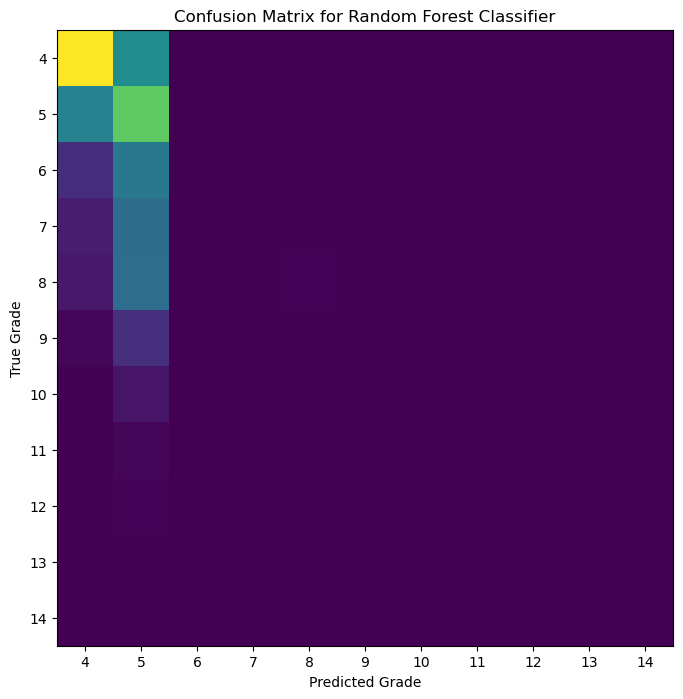

In [17]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
plt.xticks(np.arange(11), np.arange(4, 15))
plt.yticks(np.arange(11), np.arange(4, 15))
plt.xlabel('Predicted Grade')
plt.ylabel('True Grade')
plt.title('Confusion Matrix for CNN Classifier')